# Load Model

In [ ]:
import numpy as np
import os
import torch
import torch.nn.functional as F

from KDLAE_model import KDLAE_student
from skimage import img_as_ubyte

from glob import glob
import cv2


# Sample for US
opt = {
    'dataroot_lq': '../Sample/CAMUS/origin/',
    'weights_path': 'weights/KDLAE-S-US.pth',
    'inp_channels': 7
}

# Sample for FLS
# opt = {
#     'dataroot_lq': '../Sample/MDD/origin/',
#     'weights_path': 'weights/KDLAE-S-FLS.pth',
#     'inp_channels': 7

# }

model_restoration = KDLAE_student(inp_channels=1, out_channels=1, residual=True, hidden_channels=[16, 32, 64])


checkpoint = torch.load(opt['weights_path'])
model_restoration.load_state_dict(checkpoint['params'])
print("===>Testing using weights: ",opt['weights_path'])

# Specify the GPU device
device = torch.device("cuda:0")  # Here, "cuda:0" is the device identifier for the first GPU
model_restoration.to(device)  # Move the model to the specified GPU

model_restoration.eval()


===>Testing using weights:  weights/KDLAE-S-US.pth


KDLAE_student(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pooling_layers): ModuleList(
    (0-1): 2 x MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (st_fusion): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv_layers): ModuleList(
    (0): C

# Predict

torch.Size([1, 7, 551, 585])


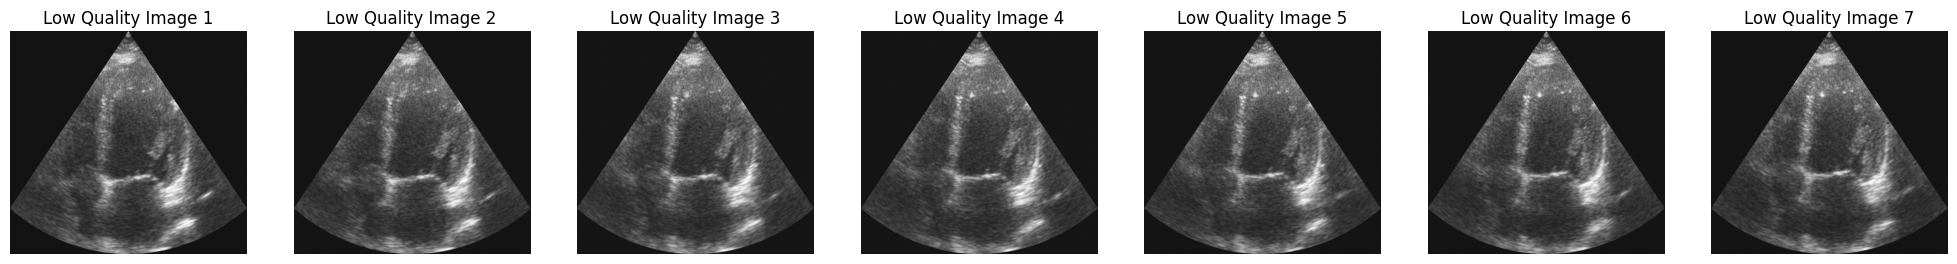

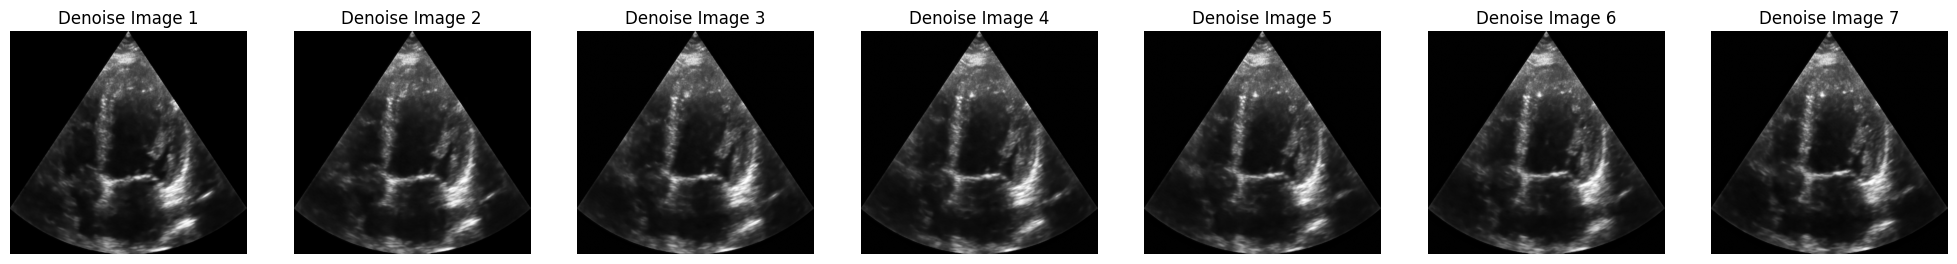

In [46]:
import matplotlib.pyplot as plt
import random
 
# plt.ioff()  # Disable interactive mode

save_dir = '.denoise/' 
os.makedirs(save_dir, exist_ok=True)
saveflag = False
plotflag = True
inp_channels=opt['inp_channels']


img_multiple_of = 32

# 直接从文件夹读取连续的 inp_channels 张图像，拼成 [1, C, H, W]
def load_consecutive_stack(folder: str, num_frames: int) -> torch.Tensor:
    exts = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff']
    files = []
    for e in exts:
        files.extend(glob(os.path.join(folder, e)))
    files = sorted(files)
    assert len(files) >= num_frames, f"Not enough images in {folder} (need {num_frames}, got {len(files)})"

    start = random.randint(0, len(files) - num_frames)
    seq = files[start:start+num_frames]

    frames = []
    target_size = None
    for p in seq:
        img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
        assert img is not None, f"Failed to read image: {p}"
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if target_size is None:
            target_size = (img.shape[1], img.shape[0])
        else:
            if (img.shape[1], img.shape[0]) != target_size:
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        frames.append(img)

    stack = np.stack(frames, axis=0)  # [C, H, W]
    tensor = torch.from_numpy(stack).unsqueeze(0)  # [1, C, H, W]
    return tensor

with torch.no_grad():
    lq_images = load_consecutive_stack(opt['dataroot_lq'], inp_channels).to(device)
    print(lq_images.shape)
    input_ = lq_images.float()
    h, w = input_.shape[2], input_.shape[3]
    H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
    padh = H-h if h % img_multiple_of != 0 else 0
    padw = W-w if w % img_multiple_of != 0 else 0
    input_ = F.pad(input_, (0, padw, 0, padh), 'reflect')

    restored = model_restoration(input_)
    restored = torch.clamp(restored, 0, 1)

    restored = restored[:,:,:h,:w]
    restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
    restored = img_as_ubyte(restored[0])


    if plotflag:
        b,c,h,w = lq_images.shape
        plt.figure(figsize=(25, 9))
        for channel in range(c):
            plt.subplot(1, c, channel+1)
            plt.imshow(lq_images[0 , channel, :, :].cpu(), cmap='gray')
            plt.title(f'Low Quality Image {channel+1}')
            plt.axis('off')

        split_images = [restored[:, :, k] for k in range(inp_channels)]
        plt.figure(figsize=(25, 9))
        for channel in range(c):
            plt.subplot(1, c, channel+1)
            plt.imshow(split_images[channel], cmap='gray')
            plt.title(f'Denoise Image {channel+1}')
            plt.axis('off')


    